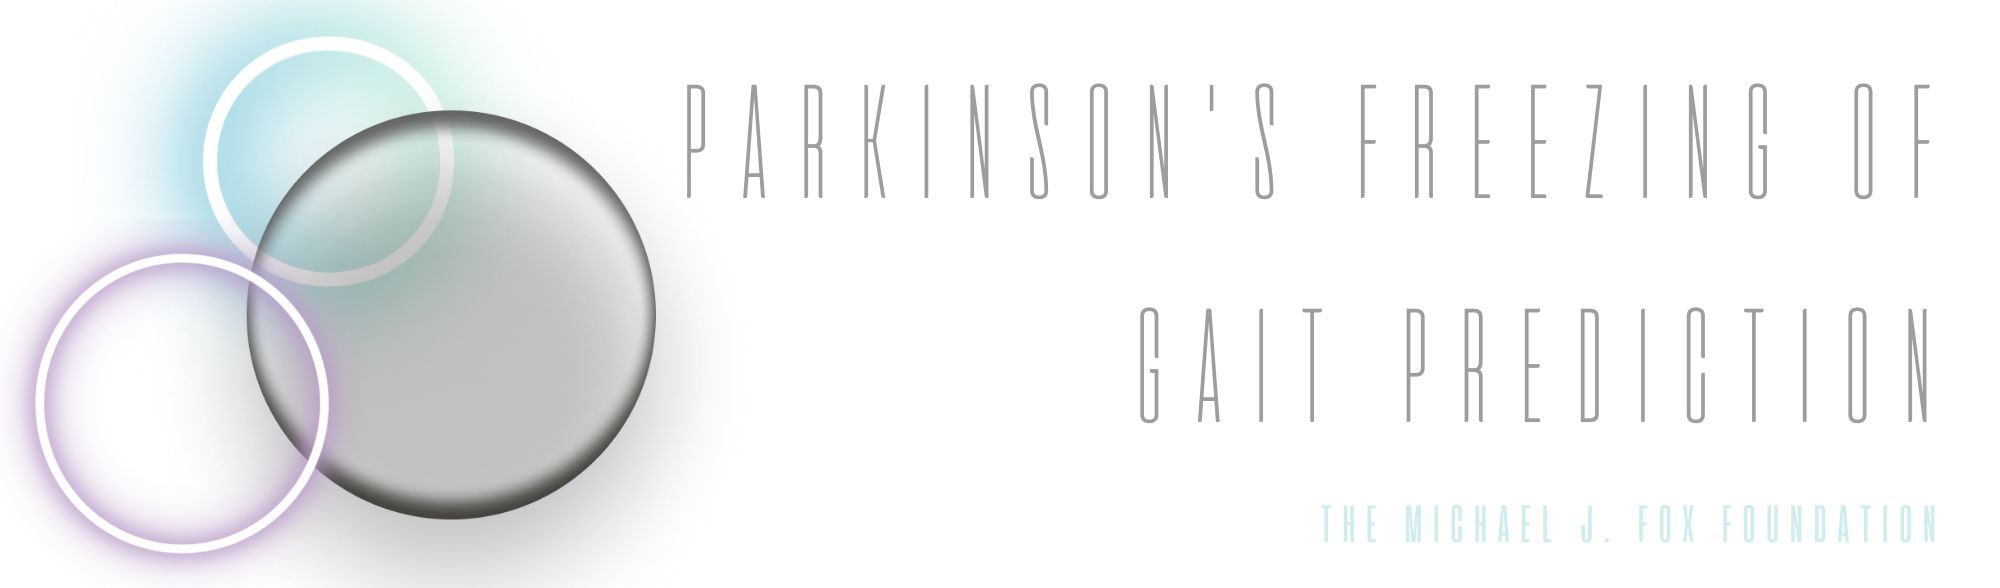

# DESCRIPTION

# Goal of the Competition  


> This competition dataset contains three-dimensional accelerometer data from the lower back of subjects who experienced episodes of gait freezing - a common disability symptom among people with Parkinson's disease. Freezing of gait (FOG) negatively impacts walking ability and impedes mobility and independence.



> Our goal is to detect the onset and cessation of each freezing episode, as well as the occurrence of three types of gait freezing events within these series: "Start hesitation", "Turn", and "Walking".  


> In this part, we will be working towards achieving our client's goal of detecting the onset and cessation of freezing episodes during gait, as well as identifying three different types of freezing events: "Start hesitation", "Turn", and "Walking". Additionally, based on the data obtained, we will develop algorithms to predict the potential onset of freezing episodes.

> We will mainly use the events.csv file Metadata for each FoG event in all data series. The time of the events corresponds to the labels in the data series.

> Description of the values:


|   Name:   |   Type:   |     Meaning:    |
|-----------|-----------|-----------------|
|  **Id**   |   num  | The data series the event occured in|
| **Init**  |   num  |Time (s) the event began|
| **Completion**  |  num  | Time (s) the event ended | 
| **Type** |  cat  | Whether StartHesitation, Turn, or Walking|
| **Kinetic** |  num - bin  | Whether the event was kinetic (1) and involved movement, or akinetic (0) and static|                           
 
 NB! **Data is in units of m/s^2 for tdcsfog/ and g for defog/ and notype / Данные представлены в единицах м/с^2 для tdcsfog/ и g для defog/ и notype** 

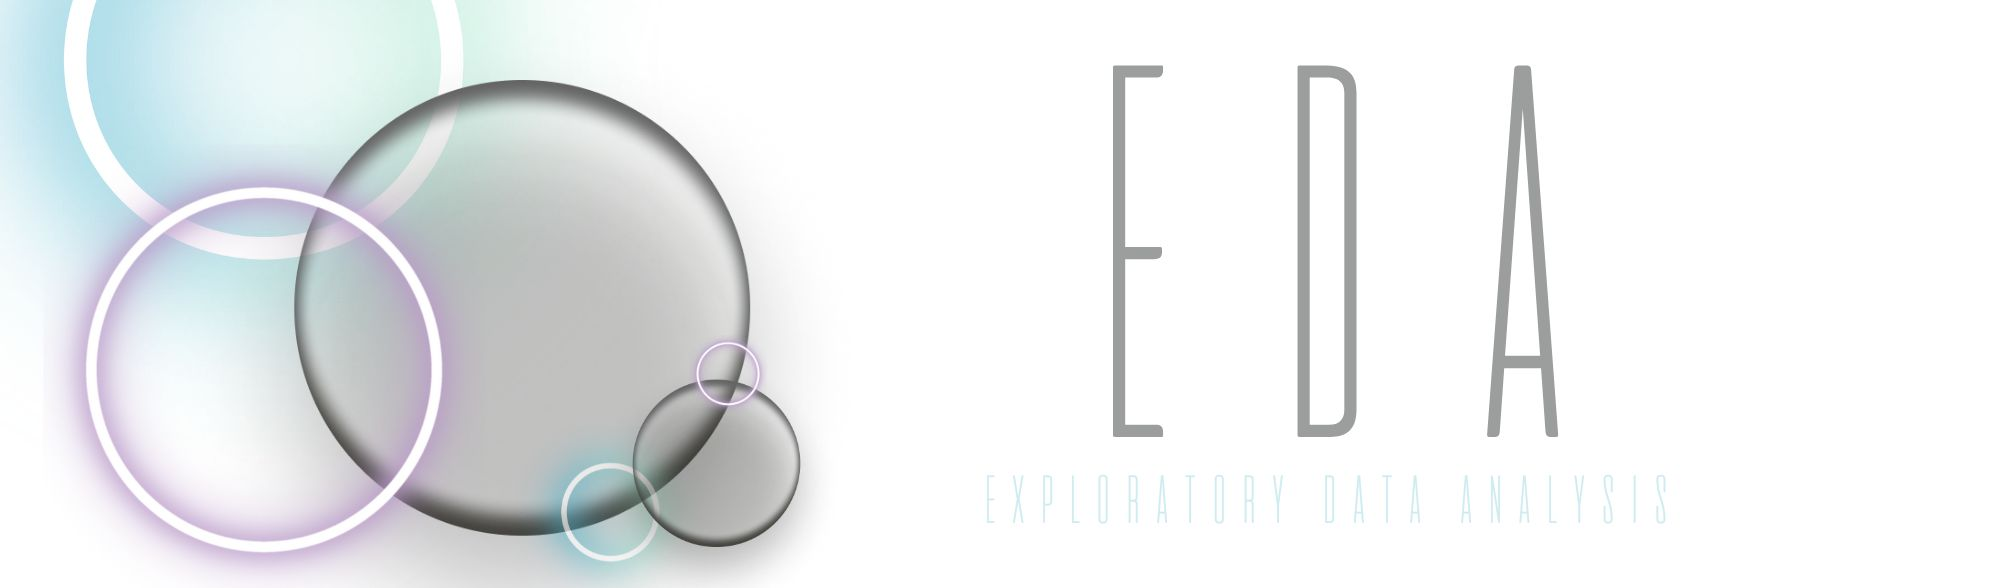

# Exploratory Data Analysis

## Imports  

*******************************

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
import optuna
from joblib import load
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Settings  

**************************

In [2]:
# Pandas defaults
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.colheader_justify = 'left'

In [3]:
# others
warnings.filterwarnings('ignore')

## Constants  

*****************************************

In [4]:
#PATH_REMOTE = ''                    # remote path to data

CR = '\n'                                     # new line
RANDOM_STATE = RANDOM_SEED = RS = 66          # random_state
TEST_FRAC = 0.1                               # delayed sampling fraction

N_TRIALS = 10                                 # number of tries for fitting of hyperparameters
N_CV = 4                                      # number of folds during cross-validation
MAX_ITER = 1000                               # max number of iterations for LinearRegression
DEGREE_POLYNOMIAL = 5                         # degree for polynomial expansion

# Data preparation  

***************************************************************************

## Read and Check data


In [5]:
# Daily, Defog, and Tdcsfog data:
# daily_df = pd.read_csv('C:/Users/Admin/Desktop/DS studies/Data/Parkinsons/Data/daily_metadata.csv')
# defog_df = pd.read_csv('C:/Users/Admin/Desktop/DS studies/Data/Parkinsons/Data/defog_metadata.csv')
# tdcsfog_df = pd.read_csv('C:/Users/Admin/Desktop/DS studies/Data/Parkinsons/Data/tdcsfog_metadata.csv')
# #/kaggle/input/copy-train-metadata/tdcsfog_metadata.csv
# #
# # Other three dataframes:
events_df = pd.read_csv('C:/Users/Admin/Desktop/DS studies/Data/Parkinsons/Data/events.csv')
# subjects_df = pd.read_csv('C:/Users/Admin/Desktop/DS studies/Data/Parkinsons/Data/subjects.csv')
# tasks_df = pd.read_csv('C:/Users/Admin/Desktop/DS studies/Data/Parkinsons/Data/tasks.csv')

In [6]:
df = events_df

df.head()

,Id,Init,Completion,Type,Kinetic
0,003f117e14,8.61,14.77,Turn,1.00
1,009ee11563,11.38,41.18,Turn,1.00
2,009ee11563,54.66,58.78,Turn,1.00
3,011322847a,28.10,30.30,Turn,1.00
4,01d0fe7266,30.32,31.88,Turn,1.00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3712 entries, 0 to 3711
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          3712 non-null   object 
 1   Init        3712 non-null   float64
 2   Completion  3712 non-null   float64
 3   Type        2669 non-null   object 
 4   Kinetic     2669 non-null   float64
dtypes: float64(3), object(2)
memory usage: 145.1+ KB


In [8]:
def preprocess_data(df):
    """
    A function for data preprocessing that takes a DataFrame as input and returns 
    a DataFrame after applying necessary transformations
    """
    # Removing duplicates
    df.drop_duplicates(inplace=True)

    # Converting categorical features
    df['Type'] = df['Type'].astype('category')
    df['StartHesitation'] = np.where(df['Type'] == 'StartHesitation', 1, 0)
    df['Turn'] = np.where(df['Type'] == 'Turn', 1, 0)
    df['Walking'] = np.where(df['Type'] == 'Walking', 1, 0)

    # Creating a feature called Duration
    df['Duration'] = df['Completion'] - df['Init']

    # Defining the value of the target feature
    df['Target'] = np.where(df['Type'] == 'StartHesitation', df['StartHesitation'], np.where(df['Type'] == 'Turn', df['Turn'], df['Walking']))

    return df


In [9]:
def get_X_y(df):
    """
    A function to split a DataFrame into a feature matrix X and a target variable vector y
    """
    X = df.drop(['StartHesitation', 'Turn', 'Walking', 'Target'], axis=1)
    y = df['Target']
    return X, y

In [10]:
def evaluate_model(X, y, model):
    """
    A function for evaluating the model's performance using cross-validation
    """
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    return np.mean(scores), np.std(scores)

In [11]:

def evaluate_submission(y_true, y_pred):
    """
   A function for evaluating the quality of predictions on test data
    """
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    return acc, cm

# Data preprocessing

df = preprocess_data(df)

In [12]:
df

,Id,Init,Completion,Type,Kinetic,StartHesitation,Turn,Walking,Duration,Target
0,003f117e14,8.61,14.77,Turn,1.00,0,1,0,6.16,1
1,009ee11563,11.38,41.18,Turn,1.00,0,1,0,29.80,1
2,009ee11563,54.66,58.78,Turn,1.00,0,1,0,4.12,1
3,011322847a,28.10,30.30,Turn,1.00,0,1,0,2.20,1
4,01d0fe7266,30.32,31.88,Turn,1.00,0,1,0,1.56,1
...,...,...,...,...,...,...,...,...,...,...
3707,f9fc61ce85,628.56,631.66,Walking,0.00,0,0,1,3.11,1
3708,f9fc61ce85,782.50,782.65,Walking,1.00,0,0,1,0.15,1
3709,f9fc61ce85,931.94,933.45,Turn,1.00,0,1,0,1.51,1
3710,f9fc61ce85,990.86,991.86,Turn,0.00,0,1,0,1.00,1


The original DataFrame contains 3712 records and 5 features. In this case, categorical feature conversion, duplicate removal, creation of a new feature called Duration, and determination of the target feature called Target are performed

The preprocess_data function performs data preprocessing, including duplicate removal, categorical feature conversion, creation of the Duration feature, and determination of the target feature

The get_X_y function splits the DataFrame into a feature matrix X and a target variable vector y

The evaluate_model function evaluates the model's performance using cross-validation

The evaluate_submission function evaluates the quality of predictions on test data

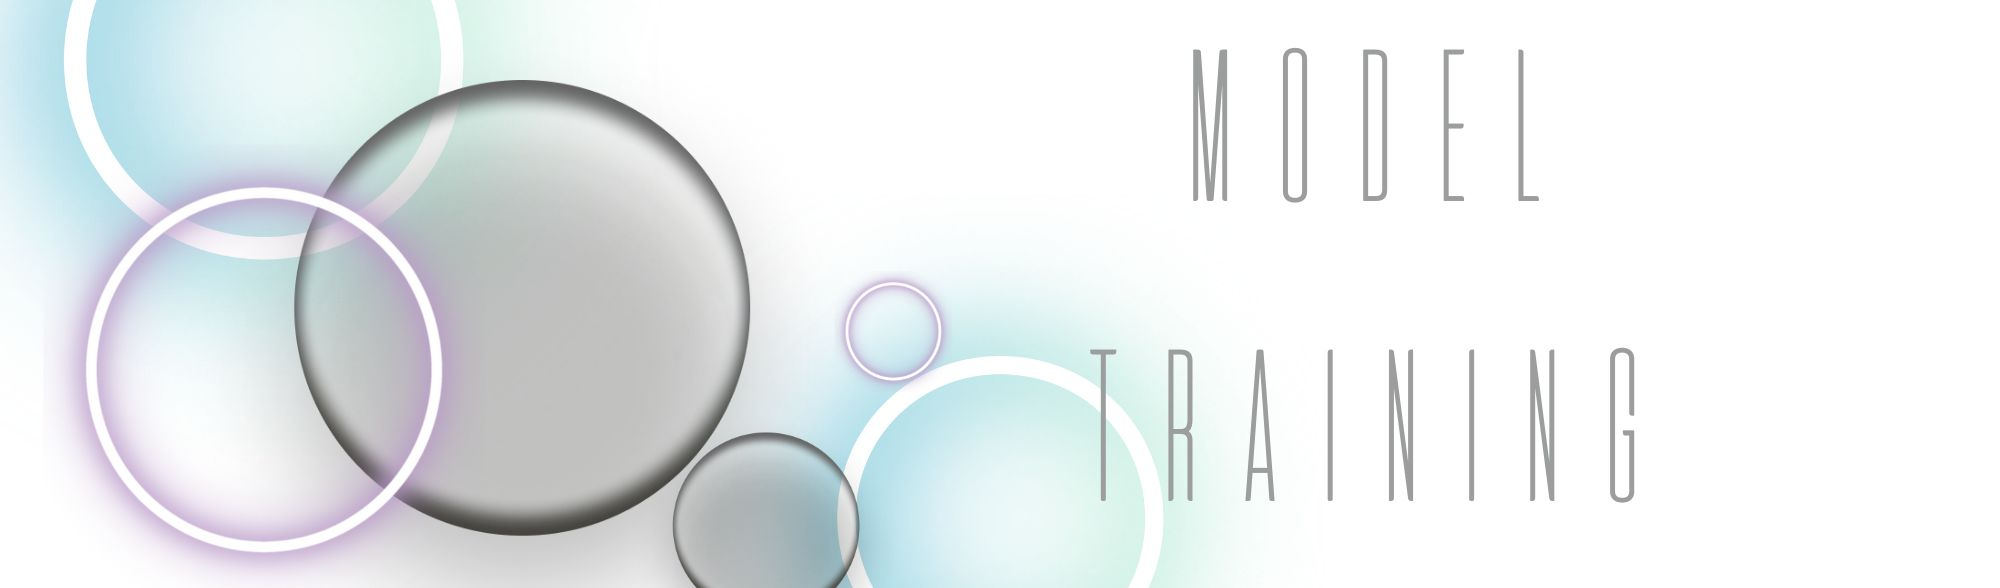

In [13]:
# Splitting the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(df.drop('Target', axis=1), df['Target'], test_size=0.2, random_state=42)

In [14]:
# Creating a list of numerical and categorical features

num_features = ['Init', 'Completion', 'Duration', 'StartHesitation','Turn', 'Walking', 'Kinetic']
cat_features = ['Id', 'Type']

In [15]:
# Creating transformers for numerical and categorical features

num_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
('imputer', SimpleImputer
(strategy='most_frequent')),
('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [16]:
# Combining transformers using ColumnTransformer

preprocessor = ColumnTransformer(
transformers=[
('num', num_transformer, num_features),
('cat', cat_transformer, cat_features)
])

In [17]:
# Combining data preprocessing and model into a single pipeline

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
('classifier', RandomForestClassifier())])

In [18]:
# Training the model

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Init', 'Completion',
                                                   'Duration',
                                                   'StartHesitation', 'Turn',
                                                   'Walking', 'Kinetic']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                

In [19]:
# Making predictions

predictions = pipeline.predict(X_test)

In [20]:
# Concatenating all predicted data into one DataFrame

all_predictions = pd.DataFrame({'Id': X_test['Id'], 'Predictions': predictions})

In [21]:
# Printing the accuracy of the model on the test set

print(f"Accuracy score on test set: {accuracy_score(y_test, predictions)}")

Accuracy score on test set: 1.0


In [22]:
# Creating a DataFrame with the desired number of rows

submission_df = pd.DataFrame({'Id': [f'003f117e14_{i}' for i in range(1, 286371)],
                              'StartHesitation': 0,
                              'Turn': 0,
                              'Walking': 0})

# Adding predicted values to the corresponding columns

for i in range(len(predictions)):
    id_str = f'003f117e14_{i+1}' # rows id 
    if id_str in submission_df['Id'].values:
        submission_df.loc[submission_df['Id']==id_str, ['StartHesitation', 'Turn', 'Walking']] = predictions[i]
        
# Saving the DataFrame to a CSV file
submission_df.to_csv('C:/Users/Admin/Desktop/DS studies/Data/Parkinsons/v_2/submission.csv', index=False)

In [23]:
submission_df = pd.read_csv('C:/Users/Admin/Desktop/DS studies/Data/Parkinsons/v_2/submission.csv')
print(submission_df.columns)
print(submission_df.shape)
print(submission_df)

Index(['Id', 'StartHesitation', 'Turn', 'Walking'], dtype='object')
(286370, 4)
       Id                  StartHesitation  Turn  Walking
0            003f117e14_1  1                1     1      
1            003f117e14_2  1                1     1      
2            003f117e14_3  1                1     1      
3            003f117e14_4  0                0     0      
4            003f117e14_5  0                0     0      
...                   ...              ...   ...      ...
286365  003f117e14_286366  0                0     0      
286366  003f117e14_286367  0                0     0      
286367  003f117e14_286368  0                0     0      
286368  003f117e14_286369  0                0     0      
286369  003f117e14_286370  0                0     0      

[286370 rows x 4 columns]


In [24]:
# # Save model
# joblib.dump(pipeline, 'model.joblib')

# # Load model
# loaded_pipeline = joblib.load('model.joblib')

In [25]:
# file_path = 'C:/Users/Admin/Desktop/DS studies/Data/Parkinsons/v_2/model.joblib'

In [26]:
# loaded_pipeline = joblib.load(file_path)
# loaded_pipeline.predict(X_test)

In [27]:
os.listdir()

['.ipynb_checkpoints',
 'About the contest in code.txt',
 'Data',
 'Data experiment. EDA and two models FOG vs Age.ipynb',
 'Descriptions.txt',
 'model.joblib',
 'PARCINSON Part 1_DP.ipynb',
 'PARCINSON Part 2_EDA-Copy1.ipynb',
 'PARCINSON Part 2_FE.ipynb',
 'PARCINSON Part 3_ML.ipynb',
 'PARCINSON v2.ipynb',
 'PARCINSON v4.ipynb',
 'rf_model.pkl',
 'submission.csv',
 'TARGET events.csv PARCINSON .ipynb',
 'Untitled.ipynb',
 'v_1',
 'v_2']